In [ ]:
# Import ibraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
df = pd.read_csv('/content/Statewide Solar Projects.csv')
df

Data Through Date Project ID  ... Energy Storage System Size (kWac) Number of Projects
0             12/31/2023  SDG-66301  ...                               NaN                  1
1             12/31/2023  SDG-66299  ...                               NaN                  1
2             12/31/2023  SDG-66288  ...                               NaN                  1
3             12/31/2023  SDG-66284  ...                               NaN                  1
4             12/31/2023  SDG-66277  ...                               NaN                  1
...                  ...        ...  ...                               ...                ...
218110        12/31/2023       49.0  ...                               NaN                  1
218111        12/31/2023       48.0  ...                               NaN                  1
218112        12/31/2023        NaN  ...                               NaN                  1
218113        12/31/2023        NaN  ...                               NaN                  1
218114        12/31/2023        NaN  ...                               NaN                  1

[218115 rows x 17 columns]

In [ ]:
df.head()

Data Through Date Project ID  ... Energy Storage System Size (kWac) Number of Projects
0        12/31/2023  SDG-66301  ...                               NaN                  1
1        12/31/2023  SDG-66299  ...                               NaN                  1
2        12/31/2023  SDG-66288  ...                               NaN                  1
3        12/31/2023  SDG-66284  ...                               NaN                  1
4        12/31/2023  SDG-66277  ...                               NaN                  1

[5 rows x 17 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218115 entries, 0 to 218114
Data columns (total 17 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Data Through Date                            218115 non-null  object 
 1   Project ID                                   218112 non-null  object 
 2   Interconnection Date                         218115 non-null  object 
 3   Utility                                      218115 non-null  object 
 4   City/Town                                    218057 non-null  object 
 5   County                                       218115 non-null  object 
 6   Zip                                          218019 non-null  float64
 7   Division                                     132881 non-null  object 
 8   Substation                                   138171 non-null  object 
 9   Circuit ID                                   218085 non-nul

In [ ]:
df.isnull().sum()

Data Through Date                                   0
Project ID                                          3
Interconnection Date                                0
Utility                                             0
City/Town                                          58
County                                              0
Zip                                                96
Division                                        85234
Substation                                      79944
Circuit ID                                         30
Developer                                       10550
Metering Method                                   463
Estimated PV System Size (kWdc)                     0
PV System Size (kWac)                               0
Estimated Annual PV Energy Production (kWh)         0
Energy Storage System Size (kWac)              214024
Number of Projects                                  0
dtype: int64

In [ ]:
# Data Cleaning
df['Zip'] = df['Zip'].astype(str).str.split('.').str[0]
df['City/Town'].fillna('Unknown', inplace=True)
df['Division'].fillna('Unknown', inplace=True)
df['Substation'].fillna('Unknown', inplace=True)
df['Energy Storage System Size (kWac)'].fillna(0, inplace=True)
df_cleaned = df.dropna(subset=['Estimated Annual PV Energy Production (kWh)', 'County'])

In [ ]:
df.isnull().sum()

Data Through Date                                  0
Project ID                                         3
Interconnection Date                               0
Utility                                            0
City/Town                                          0
County                                             0
Zip                                                0
Division                                           0
Substation                                         0
Circuit ID                                        30
Developer                                      10550
Metering Method                                  463
Estimated PV System Size (kWdc)                    0
PV System Size (kWac)                              0
Estimated Annual PV Energy Production (kWh)        0
Energy Storage System Size (kWac)                  0
Number of Projects                                 0
dtype: int64

In [ ]:
df['Developer'].fillna(df['Developer'].mode()[0], inplace=True)
df['Metering Method'].fillna(df['Metering Method'].mode()[0], inplace=True)
df.fillna(0, inplace=True)

In [ ]:
# Aggregate energy production by County
county_energy = df_cleaned.groupby("County")[["Estimated Annual PV Energy Production (kWh)"]].sum().reset_index()

In [ ]:
county_energy

County  Estimated Annual PV Energy Production (kWh)
0        Albany                                    115095306
1      Allegany                                     76322953
2         Bronx                                     83693477
3        Broome                                     39218012
4   Cattaraugus                                     68467827
..          ...                                          ...
57   Washington                                     47853059
58        Wayne                                     60311545
59  Westchester                                    230581827
60      Wyoming                                     33352776
61        Yates                                     48916525

[62 rows x 2 columns]

In [ ]:
# Normalize Data for Clustering
scaler = StandardScaler()
county_energy_scaled = scaler.fit_transform(county_energy[["Estimated Annual PV Energy Production (kWh)"]])

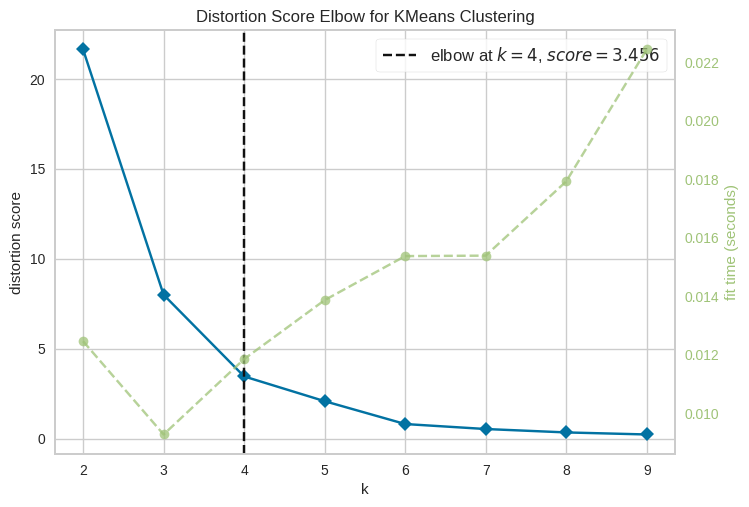

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Find Optimal Clusters using Elbow Method
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')
visualizer.fit(county_energy_scaled)
visualizer.show()

In [ ]:
# Apply K-Means Clustering with Optimal K
optimal_k = visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
county_energy["Cluster"] = kmeans.fit_predict(county_energy_scaled)

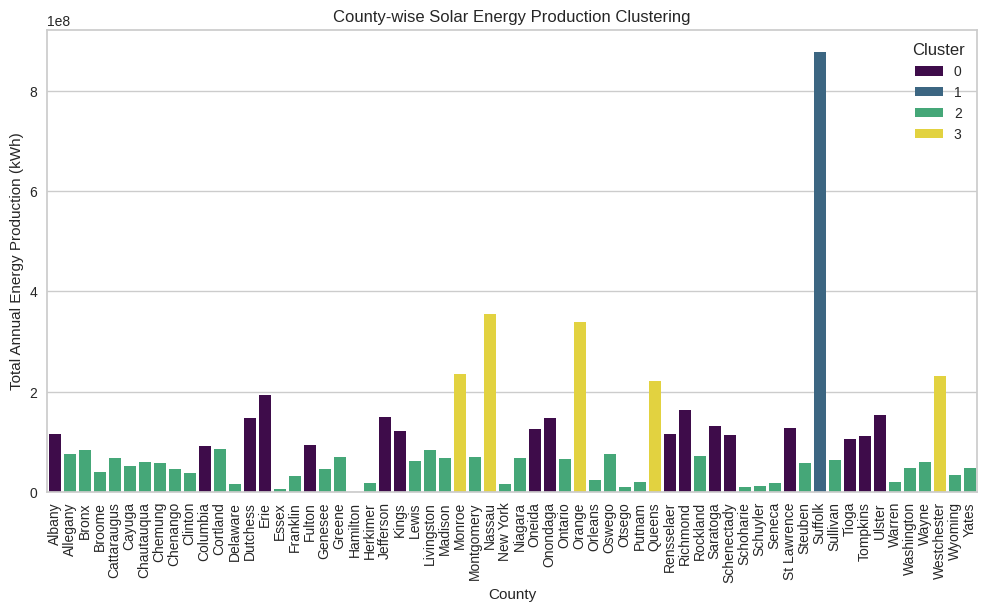

In [ ]:
# Plot Energy Production by County with Clusters
plt.figure(figsize=(12, 6))
sns.barplot(data=county_energy, x="County", y="Estimated Annual PV Energy Production (kWh)", hue="Cluster", palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("County")
plt.ylabel("Total Annual Energy Production (kWh)")
plt.title("County-wise Solar Energy Production Clustering")
plt.legend(title="Cluster")
plt.show()